# Time series forecasting

RNN (Recurrent Neural Network)의 Long Short Term Memory ( LSTM ) 모델 사용

https://www.tensorflow.org/tutorials/structured_data/time_series

In [2]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The weather dataset
날씨 데이터 세트

Max Planck Institute for Biogeochemistry에 의해 기록 된 [날씨 시계열 데이터 세트]를 사용

대기 온도, 대기압 및 습도와 같은 14 가지 특징으로 구성
2009 년과 2016 년 사이에 수집 된 데이터 만 사용

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
print(csv_path)

C:\Users\hjsong\.keras\datasets\jena_climate_2009_2016.csv


In [4]:
#pandas dataframe으로 csv파일 read
df = pd.read_csv(csv_path)

In [54]:
df.shape

(420551, 15)

In [5]:
# 상위 데이터 목록 확인
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


10 분마다 기록된 데이터 (한 시간 동안 6 개의 관측 값) , 하루에 144 개 (6x24)의 관측치가 포함  

### 데이터 윈도우

데이터의 연속 샘플 창을 기반으로 일련의 예측을 수행  

6 시간의 히스토리가 주어 졌을 때 미래를 1 시간으로 예측하는 모델에 사용되는 데이터 윈도우

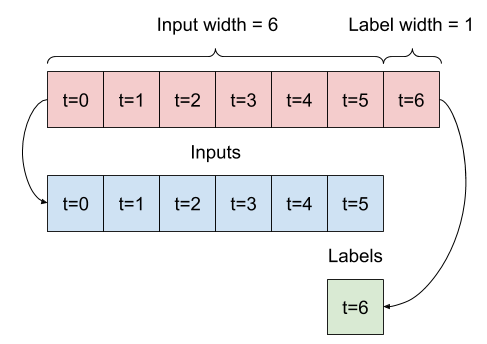

* 날씨 데이터 예   
 5일간의 관측값을 이용하여  미래의 6 시간 동안 온도를 예측하기 위한 데이터 위도우   
   특정시간을 기준으로  과거정보(history)에 해당하는 720 (5 * 144) 관측 값이 입력 데이터 window로 설정되고  
   특정시간 이후의 36개 (6* 6) 관측값이 출력 라벨(target label)로 설정

* univariate_data()  
모델이 학습할 때 사용할 데이터 window를 반환   (data, label)   
매개 변수    
  - history_size : 과거 정보 window size,   입력 데이터 크기
  - target_size  : 출력 라벨(target label), 예측라벨 크기  

In [57]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

데이터의 처음 300,000 개 행은 학습 데이터 세트(2100일 분량)이고 나머지는 유효성 검사 데이터 세트로 구성

In [58]:
TRAIN_SPLIT = 300000

재현성을 보장하기 위해 시드 설정.

In [59]:
tf.random.set_seed(13)

## Forecast a univariate time series

#### 단일 특징 (온도, temperature) 만 사용하여 모델을 학습하고 해당 값을 예측

### (1)데이터 셋에서 온도만 추출

In [60]:
#extract only the temperature from the dataset.
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

### (2)시간에 따른 온도 시각화

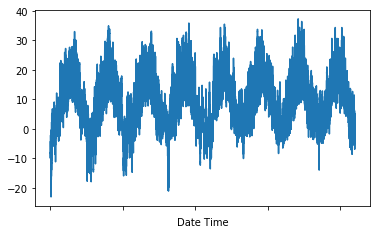

In [61]:
uni_data.plot(subplots=True)
plt.show()

### (3)Standardization  
- 평균, 표준편차를 구하여 스케일링 처리  
- keras.utils.normalize를 이용하여 [0,1] 범위로 재조정 하는 방법을 사용해도됨

In [11]:
#uni_data에서 값만 추출
uni_data = uni_data.values

In [12]:
#평균, 표준편차 구하기
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [13]:
# Standardization (표준화)
uni_data = (uni_data-uni_train_mean)/uni_train_std

### (4) univariate_data 추출
지난 20 개의 온도 관측 기록을 사용하여 현재 시간 온도 예측을 위한 데이터 추출

* window 추출  
x : 지난 20 개의 온도 관측값  
y : 현재시간의 관측값

In [14]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

* `univariate_data` function 결과 확인  
추출된 입력 데이터와 출력 라벨 확인

In [15]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


* 예측 결과 plotting 함수 정의

In [16]:
def create_time_steps(length):
  return list(range(-length, 0))

In [40]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])  #history plot
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])  #target label plot
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

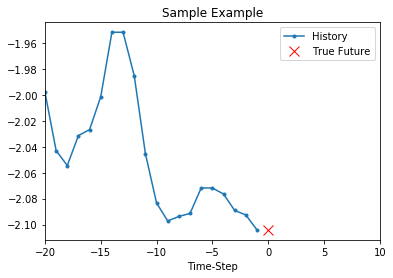

In [41]:
#0번째 학습데이터에 대한 플로팅
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')
plt.show()

### (5) Baseline
모델 학습전에 기준선 결정, 과거 20개 관측값의 평균점을 모델 예측으로 정하여 출력

In [48]:
#평균값의 예측 기준값으로 계산
def baseline(history):
  return np.mean(history)

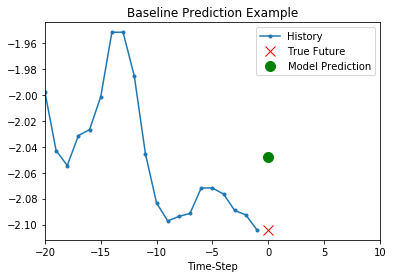

In [49]:
#입력(history), 라벨(target),예측(baseline)에 대한 플로팅
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')
plt.show()

### (6) LSTM 데이터 입력  구조

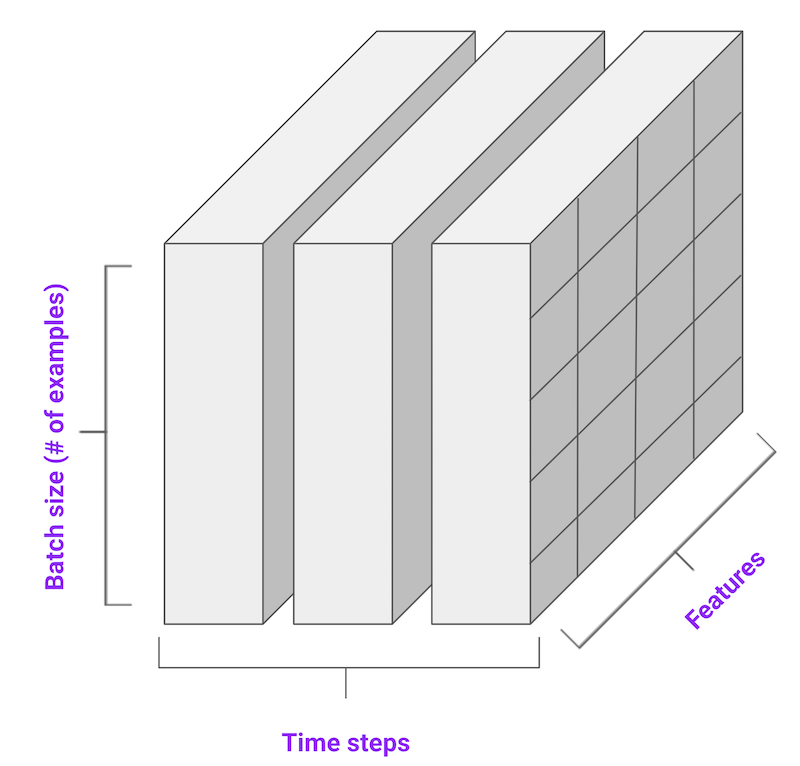

In [50]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

#train, validation  data를 텐서로 변경하여 batch size만큼 추출
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

### (7) LSTM model 구성

In [51]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),    #output unit size = 8
    tf.keras.layers.Dense(1)  #숫자 1개 출력, 
])

simple_lstm_model.compile(optimizer='adam', loss='mae')   #regression

### (8) sample prediction

검증데이터 1개를 가져와서 예측한 출력 결과 확인


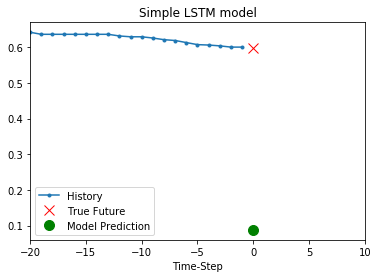

In [52]:
for x, y in val_univariate.take(1):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

### (9)train the model


In [53]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 1s 7ms/step - loss: 0.3891 - val_loss: 0.0919
Epoch 2/10
200/200 [==============================] - 1s 6ms/step - loss: 0.1066 - val_loss: 0.0329
Epoch 3/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0484 - val_loss: 0.0247
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0416 - val_loss: 0.0214
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0260 - val_loss: 0.0200
Epoch 6/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0280 - val_loss: 0.0193
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0259 - val_loss: 0.0188
Epoch 8/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0245 - val_loss: 0.0176
Epoch 9/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0236 - val_loss: 0.0169
Epoch 10/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0216 - val_loss: 0.0162

### (10) Predict using the simple LSTM model
학습된 simple LSTM으로 예측결과 확인

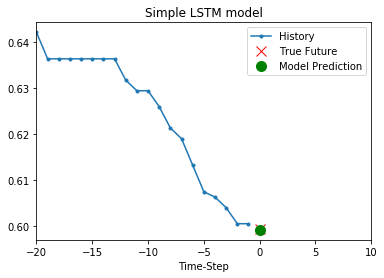

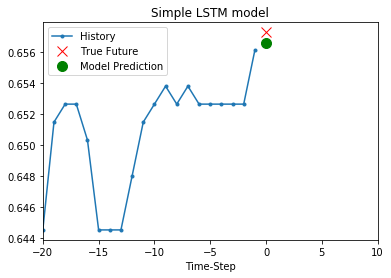

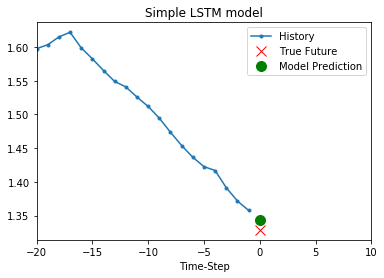

In [33]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()